In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from cataclop.ml import preprocessing
from cataclop.ml import exploration

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [2]:
program = factories.Program.factory('default', version='1.1')

In [3]:
program.predict(dataset_params = {
    'from': '2018-01-01',
    'to': '2018-12-31',
    'categories': ['ATTELE']
}, model_params = {
    'kfolds': 3,
    'nan_flag': 100000
})

preparing model data
preparing stacked model data


In [4]:
def bet(df, features, categorical_features, targets, N=1, max_odds=20, break_on_bet=True, break_on_odds=False):

    races = df.sort_values('start_at').groupby('race_id')

    bets = []

    for (id, race) in races:

        candidate_bets = []

        nums = []

        for target in targets:

            r = race.sort_values(by=target, ascending=False)

            if len(r) <= N:
                break
                
            NN = N

            for n in range(NN):

                player = r.iloc[n]

                odds = player['final_odds_ref']

                if max_odds is not None and odds > max_odds:
                    if break_on_odds:
                        break
                    else:
                        continue

                #nth = (r['final_odds_ref']<odds).sum()+1
                
                if player[target] < 0:
                    break

                bet = np.clip(player[target]/100.0, 0, 10)
                
                bet = np.round(1+bet) * 1.5
                
                if bet <= 0:
                    break
                
                if n+1 < len(r) and r.iloc[n+1][target] == player[target]:
                    NN = NN+1
                    
                bet = 1

                profit = player['winner_dividend']/100.0 * bet - bet

                row = [id, player['start_at'], player['num'], player['position'], n, odds, player['final_odds'], target, player[target], r[target].std(), bet, profit]

                for nn in range(1,4):
                    if n+nn < len(r):
                        row.append(r.iloc[n+nn][target])
                    else:
                        row.append(np.nan)

                for f in features:
                    row.append(player[f])
                for f in categorical_features:
                    row.append(player[f])

                candidate_bets.append( row )

                nums.append(player['num'])

                if break_on_bet:
                    break

        #if len(candidate_bets) == 1:
        #    bets += candidate_bets
        bets += candidate_bets

    cols = ['id', 'date', 'num', 'pos', 'nb', 'odds_ref', 'odds_final', 'target', 'pred', 'pred_std', 'bet', 'profit']

    for nn in range(1,4):
        cols.append('next_pred_{}'.format(nn))

    cols = cols + features + categorical_features

    bets = pd.DataFrame(bets, columns=cols)
    bets['date'] = pd.to_datetime(bets['date'])

    bets = bets.set_index(bets['date'])

    bets = bets.sort_index()

    bets['bets'] = bets['bet'].cumsum()
    bets['stash'] = bets['profit'].cumsum()

    return bets



In [5]:
df = program.df
df['pred_rnd'] = np.random.rand(df.shape[0])
df['pred_sum'] = df[['pred_{}_1'.format(model['name']) for model in program.model.models ]].sum(axis=1)


for model in program.model.models:
    df['pred_minus_ref_{}'.format(model['name'])] = df['pred_{}_1'.format(model['name'])] - df['final_odds_ref']
    
for model in program.model.stacked_models:
    df['pred_minus_ref_stacked_{}'.format(model['name'])] = df['pred_stacked_{}_1'.format(model['name'])] - df['final_odds_ref']

bets = bet(df, program.model.features, program.model.categorical_features, 
    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models] + ['pred_minus_ref_stacked_{}'.format(model['name']) for model in program.model.stacked_models] + ['pred_minus_ref_{}'.format(model['name']) for model in program.model.models]
   )
    

In [6]:
program.df.race_id.nunique()

2151

In [7]:
def graph_bb(bb, f):
    results = []

    for s in bb[f].value_counts().index:
        results = []
        x = bb[ (bb[f] == s) & (bb['pred_std'] > 0) & (bb['pred'] > 0) ].copy()
        if len(x) == 0:
            continue
        #print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))

        fig, axs = plt.subplots(1,1)

        for t in x['target'].value_counts().index:
            bbb = x[(x['target'] == t)].copy()
            #bbb = bbb[ (bbb['pred']>bbb['pred'].quantile(0.85)) ].copy()


            results.append({
                'idx_1': s,
                'idx_2': t,
                'profit': bbb.profit.sum(),
                'bet': bbb.bet.sum(),
                'bets': bbb.bet.count(),
                'avg': bbb.profit.sum() / bbb.bet.sum()
            })

            '''
            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            fig, axs = plt.subplots(1,1)
            bbb['stash'].plot(figsize=(6, 2))
            bbb['cbet'].plot(figsize=(6, 2))
            plt.show()
            '''

            #print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )

            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            bbb['stash'].plot(figsize=(10, 2))
            bbb['cbet'].plot(figsize=(10, 2))

        results = pd.DataFrame(results)
        results = results.set_index(['idx_1', 'idx_2'])
        print(results.sort_values(by='avg', ascending=False))


        plt.show()    

    
    

In [8]:
#countries = list(bets['country'].value_counts()[0:10].index)
#sub_categories = list(bets['sub_category'].value_counts()[0:10].index)

#%store countries
#%store sub_categories

In [9]:
%store -r params
%store -r countries
%store -r sub_categories

In [10]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

target = 'pred_rf_30_1'

c_min = bets[(bets['target'] == target)]['pred'].min()
c_mean = bets[(bets['target'] == target)]['pred'].mean()
c_max = bets[(bets['target'] == target)]['pred'].max()

space = [
          Real(1, 10, name='min_odds'),
          Real(10, 30, name='max_odds'),
          Real(c_min, c_mean, name='min_pred'),
          Real(c_mean, c_max, name='max_pred'),
          Integer(5, 25, name='max_players')] + [
          Integer(0,1, name='country_{}'.format(country)) for country in countries] + [
          Integer(0,1, name='sub_category_{}'.format(sub_category)) for sub_category in sub_categories] + [
          Integer(0,1, name='nb_{}'.format(n)) for n in range(0,3)]
         
def x_to_params(x):
    params = {}
    
    params['min_odds'] = x[0]
    params['max_odds'] = x[1]
    params['max_pred'] = x[3]
    params['min_pred'] = x[2]
    params['max_players'] = x[4]
    
    for i, country in enumerate(countries):
        params['country_{}'.format(country)] = x[5+i]
        
    for i, sc in enumerate(sub_categories):
        params['sub_category_{}'.format(sc)] = x[5+len(countries)+i]
        
    for n in range(0,3):
        params['nb_{}'.format(n)] = x[5+len(countries)+len(sub_categories)+n]

    return params

@use_named_args(space)
def f(**params):
    return ff(params)
    
def ff(params, train=True):
    
    print(params)
    
    b = bets[ (bets['target']==target) & (bets['pred_std'] >= 0)]
    
    b = b[ (b['odds_ref'] > params['min_odds']) & (b['odds_ref'] < params['max_odds']) & (b['declared_player_count'] > 1) & (b['declared_player_count'] <= params['max_players']) ]
    
    b = b[(b['pred'] > params['min_pred']) & (b['pred'] < params['max_pred'])]
    
    for country in countries:
        if params['country_{}'.format(country)] == 0:
            b = b[ b['country'] != country ]
            
    for sub_category in sub_categories:
        if params['sub_category_{}'.format(sub_category)] == 0:
            b = b[ b['sub_category'] != sub_category ]
            
    for n in range(0,3):
        if params['nb_{}'.format(n)] == 0:
            b = b[ b['nb'] != n]
    
    p = b.profit.sum()
    bet = b.bet.sum()
    
    print("{:+.2f} {:+.2f}\n".format(p, bet))
        
    if bet == 0:
        return 0
    
    if not train:
        return b
    
    return - (p)
    
    

In [11]:
#from skopt import dummy_minimize, gp_minimize, gbrt_minimize

#res = gbrt_minimize(f, space, n_calls=100)

In [12]:
#print(res.x, res.fun)

In [13]:
#params = x_to_params(res.x)
#%store params

In [14]:
bb = ff(params, False)

{'min_odds': 4.647410120941881, 'max_odds': 18.189219842415906, 'max_pred': 2.0174456962923584, 'min_pred': 0.19622792362774077, 'max_players': 19, 'country_FRA': 0, 'country_DEU': 0, 'country_ESP': 0, 'country_BEL': 1, 'country_NLD': 1, 'country_NOR': 0, 'country_CHE': 1, 'country_AUT': 1, 'country_AUS': 0, 'country_USA': 1, 'sub_category_AUTOSTART': 1, 'sub_category_INTERNATIONALE_AUTOSTART': 1, 'sub_category_NATIONALE_AUTOSTART': 0, 'sub_category_EUROPEENNE_AUTOSTART': 1, 'sub_category_AMATEURS_AUTOSTART': 0, 'sub_category_APPRENTIS_LADS_JOCKEYS_AUTOSTART': 0, 'sub_category_A_RECLAMER_AUTOSTART': 0, 'sub_category_GROUPE_III': 0, 'sub_category_GROUPE_I': 1, 'sub_category_GROUPE_II': 1, 'nb_0': 1, 'nb_1': 1, 'nb_2': 0}
+0.00 +0.00



                                        avg  bet  bets  profit
idx_1     idx_2                                               
AUTOSTART pred_minus_ref_knn_30   10.300000    1     1    10.3
          pred_minus_ref_knn_10    0.533333    9     9     4.8
          pred_minus_ref_knn_5     0.321739   23    23     7.4
          pred_stacked_mlp_1      -0.073993  546   546   -40.4
          pred_rnd                -0.160831  674   674  -108.4
          pred_sum                -0.192450  596   596  -114.7
          pred_knn_5_1            -0.200811  493   493   -99.0
          pred_knn_30_1           -0.205369  596   596  -122.4
          pred_knn_20_1           -0.282968  593   593  -167.8
          pred_xgb_10_1           -0.316892  592   592  -187.6
          pred_knn_10_1           -0.318081  542   542  -172.4
          pred_xgb_30_1           -0.320033  599   599  -191.7
          pred_xgb_100_1          -0.396604  589   589  -233.6
          final_odds_ref          -0.451515   66    66 

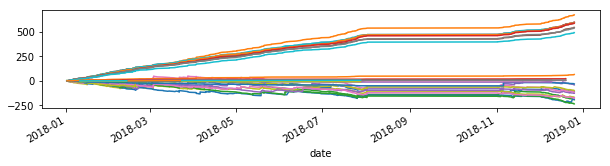

                                                      avg  bet  bets  profit
idx_1                    idx_2                                              
INTERNATIONALE_AUTOSTART pred_minus_ref_knn_5    0.566667    3     3     1.7
                         final_odds_ref          0.500000   31    31    15.5
                         pred_xgb_100_1         -0.007927  164   164    -1.3
                         pred_xgb_10_1          -0.124540  163   163   -20.3
                         pred_xgb_30_1          -0.144720  161   161   -23.3
                         pred_sum               -0.262092  153   153   -40.1
                         pred_knn_5_1           -0.264423  104   104   -27.5
                         pred_knn_10_1          -0.303361  119   119   -36.1
                         pred_rnd               -0.338415  164   164   -55.5
                         pred_stacked_mlp_1     -0.397273  110   110   -43.7
                         pred_knn_30_1          -0.469481  154   154   -72.3

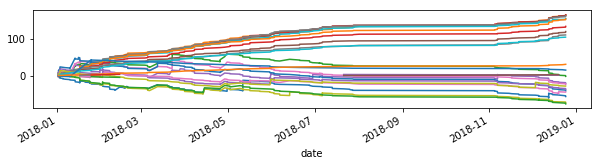

                                                 avg  bet  bets  profit
idx_1               idx_2                                              
NATIONALE_AUTOSTART pred_minus_ref_knn_5   -0.050000    4     4    -0.2
                    pred_stacked_mlp_1     -0.069118   68    68    -4.7
                    pred_knn_5_1           -0.100000   61    61    -6.1
                    pred_rnd               -0.118919   74    74    -8.8
                    pred_knn_30_1          -0.178947   76    76   -13.6
                    pred_knn_10_1          -0.227692   65    65   -14.8
                    pred_sum               -0.334328   67    67   -22.4
                    pred_xgb_10_1          -0.520833   72    72   -37.5
                    pred_xgb_30_1          -0.532000   75    75   -39.9
                    pred_xgb_100_1         -0.769565   69    69   -53.1
                    pred_knn_20_1          -0.789041   73    73   -57.6
                    final_odds_ref         -1.000000   11    11 

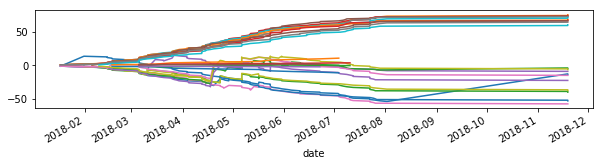

                                                  avg  bet  bets  profit
idx_1                idx_2                                              
EUROPEENNE_AUTOSTART pred_rnd                0.296296   54    54    16.0
                     pred_xgb_30_1           0.179630   54    54     9.7
                     pred_knn_30_1          -0.323077   52    52   -16.8
                     pred_stacked_mlp_1     -0.465455   55    55   -25.6
                     pred_knn_10_1          -0.482609   46    46   -22.2
                     pred_xgb_100_1         -0.535714   56    56   -30.0
                     pred_knn_5_1           -0.638095   42    42   -26.8
                     pred_xgb_10_1          -0.685714   49    49   -33.6
                     pred_sum               -0.696000   50    50   -34.8
                     pred_knn_20_1          -0.892453   53    53   -47.3
                     pred_minus_ref_xgb_30  -1.000000    3     3    -3.0
                     pred_minus_ref_xgb_100 -1.0000

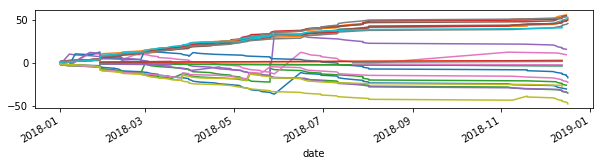

                                                avg  bet  bets  profit
idx_1              idx_2                                              
AMATEURS_AUTOSTART final_odds_ref         13.375000    4     4    53.5
                   pred_xgb_10_1           0.362857   35    35    12.7
                   pred_knn_10_1           0.150000   36    36     5.4
                   pred_xgb_100_1         -0.002439   41    41    -0.1
                   pred_stacked_mlp_1     -0.453846   39    39   -17.7
                   pred_rnd               -0.468519   54    54   -25.3
                   pred_knn_20_1          -0.717500   40    40   -28.7
                   pred_knn_5_1           -0.735484   31    31   -22.8
                   pred_knn_30_1          -0.743182   44    44   -32.7
                   pred_sum               -0.800000   41    41   -32.8
                   pred_xgb_30_1          -1.000000   38    38   -38.0
                   pred_minus_ref_knn_5   -1.000000    1     1    -1.0
      

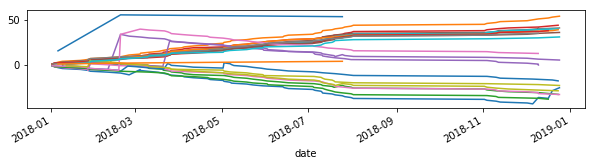

                                                          avg  bet  bets  \
idx_1                            idx_2                                     
APPRENTIS_LADS_JOCKEYS_AUTOSTART pred_rnd            0.603030   33    33   
                                 pred_knn_10_1       0.052000   25    25   
                                 pred_sum            0.006452   31    31   
                                 pred_stacked_mlp_1  0.005714   35    35   
                                 pred_knn_20_1      -0.093103   29    29   
                                 pred_knn_5_1       -0.168000   25    25   
                                 pred_xgb_10_1      -0.168750   32    32   
                                 pred_xgb_30_1      -0.261111   36    36   
                                 pred_knn_30_1      -0.550000   30    30   
                                 pred_xgb_100_1     -0.863889   36    36   
                                 final_odds_ref     -1.000000    1     1   

           

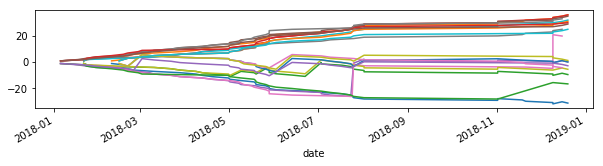

                                                avg  bet  bets  profit
idx_1                idx_2                                            
A_RECLAMER_AUTOSTART pred_rnd              1.322222    9     9    11.9
                     pred_xgb_100_1        1.162500   16    16    18.6
                     pred_knn_20_1         0.300000   13    13     3.9
                     pred_xgb_10_1        -0.261538   13    13    -3.4
                     pred_knn_30_1        -0.723077   13    13    -9.4
                     pred_knn_10_1        -0.723077   13    13    -9.4
                     pred_sum             -0.742857   14    14   -10.4
                     pred_xgb_30_1        -1.000000   14    14   -14.0
                     pred_stacked_mlp_1   -1.000000   11    11   -11.0
                     pred_knn_5_1         -1.000000   11    11   -11.0
                     pred_minus_ref_knn_5 -1.000000    2     2    -2.0


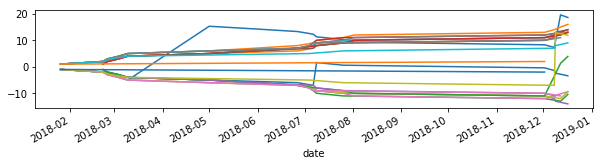

                                        avg  bet  bets  profit
idx_1      idx_2                                              
GROUPE_III pred_sum                4.414286    7     7    30.9
           pred_xgb_30_1           4.414286    7     7    30.9
           pred_xgb_100_1          3.737500    8     8    29.9
           pred_xgb_10_1           2.725000    8     8    21.8
           pred_knn_20_1           2.012500    8     8    16.1
           pred_knn_10_1           1.275000    4     4     5.1
           pred_stacked_mlp_1     -1.000000    8     8    -8.0
           pred_rnd               -1.000000    8     8    -8.0
           pred_knn_30_1          -1.000000    7     7    -7.0
           pred_knn_5_1           -1.000000    5     5    -5.0
           pred_minus_ref_xgb_100 -1.000000    1     1    -1.0


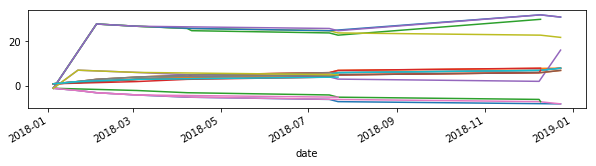

                                                                   avg  bet  \
idx_1                                       idx_2                             
APPRENTIS_LADS_JOCKEYS_A_RECLAMER_AUTOSTART pred_xgb_30_1       0.2600    5   
                                            pred_rnd           -0.2125    8   
                                            pred_xgb_10_1      -1.0000    6   
                                            pred_knn_20_1      -1.0000    5   
                                            pred_xgb_100_1     -1.0000    5   
                                            pred_knn_30_1      -1.0000    5   
                                            pred_stacked_mlp_1 -1.0000    5   
                                            pred_sum           -1.0000    4   
                                            pred_knn_5_1       -1.0000    4   
                                            pred_knn_10_1      -1.0000    4   

                                                   

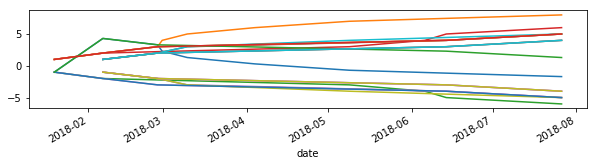

                                                      avg  bet  bets  profit
idx_1                             idx_2                                     
AMATEURS_INTERNATIONALE_AUTOSTART pred_xgb_100_1     -1.0    6     6    -6.0
                                  pred_sum           -1.0    4     4    -4.0
                                  pred_xgb_10_1      -1.0    4     4    -4.0
                                  pred_rnd           -1.0    4     4    -4.0
                                  pred_xgb_30_1      -1.0    4     4    -4.0
                                  pred_knn_5_1       -1.0    3     3    -3.0
                                  pred_knn_30_1      -1.0    3     3    -3.0
                                  pred_knn_20_1      -1.0    3     3    -3.0
                                  pred_stacked_mlp_1 -1.0    2     2    -2.0
                                  pred_knn_10_1      -1.0    2     2    -2.0


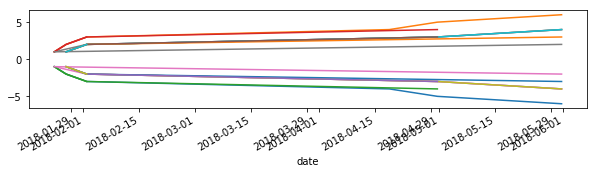

                               avg  bet  bets  profit
idx_1    idx_2                                       
GROUPE_I pred_xgb_10_1        -1.0    3     3    -3.0
         pred_stacked_mlp_1   -1.0    3     3    -3.0
         pred_knn_20_1        -1.0    3     3    -3.0
         pred_knn_30_1        -1.0    2     2    -2.0
         pred_knn_10_1        -1.0    2     2    -2.0
         pred_sum             -1.0    1     1    -1.0
         pred_minus_ref_knn_5 -1.0    1     1    -1.0
         pred_xgb_100_1       -1.0    1     1    -1.0
         pred_knn_5_1         -1.0    1     1    -1.0
         pred_rnd             -1.0    1     1    -1.0
         pred_xgb_30_1        -1.0    1     1    -1.0


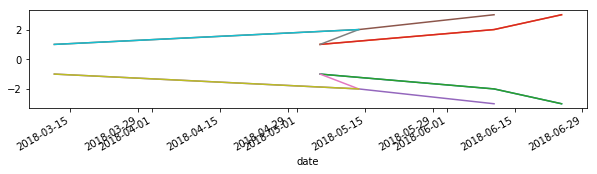

                                 avg  bet  bets  profit
idx_1   idx_2                                          
INCONNU pred_xgb_10_1       0.366667    3     3     1.1
        pred_sum           -1.000000    3     3    -3.0
        pred_xgb_30_1      -1.000000    3     3    -3.0
        pred_stacked_mlp_1 -1.000000    2     2    -2.0
        pred_rnd           -1.000000    2     2    -2.0
        pred_knn_10_1      -1.000000    1     1    -1.0
        pred_xgb_100_1     -1.000000    1     1    -1.0
        pred_knn_5_1       -1.000000    1     1    -1.0
        pred_knn_30_1      -1.000000    1     1    -1.0
        pred_knn_20_1      -1.000000    1     1    -1.0


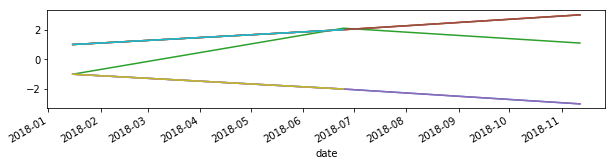

                              avg  bet  bets  profit
idx_1     idx_2                                     
GROUPE_II pred_xgb_10_1      -1.0    2     2    -2.0
          pred_sum           -1.0    1     1    -1.0
          pred_knn_20_1      -1.0    1     1    -1.0
          pred_xgb_100_1     -1.0    1     1    -1.0
          pred_knn_5_1       -1.0    1     1    -1.0
          pred_knn_30_1      -1.0    1     1    -1.0
          pred_stacked_mlp_1 -1.0    1     1    -1.0
          pred_rnd           -1.0    1     1    -1.0
          pred_knn_10_1      -1.0    1     1    -1.0
          pred_xgb_30_1      -1.0    1     1    -1.0


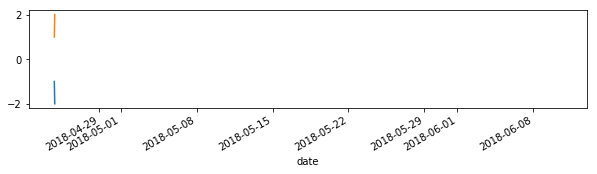

                                              avg  bet  bets  profit
idx_1                         idx_2                                 
AMATEURS_EUROPEENNE_AUTOSTART pred_xgb_100_1  1.8    1     1     1.8
                              pred_xgb_30_1   0.4    2     2     0.8
                              pred_xgb_10_1  -1.0    1     1    -1.0
                              pred_knn_5_1   -1.0    1     1    -1.0
                              pred_knn_30_1  -1.0    1     1    -1.0
                              pred_knn_20_1  -1.0    1     1    -1.0
                              pred_rnd       -1.0    1     1    -1.0
                              pred_knn_10_1  -1.0    1     1    -1.0


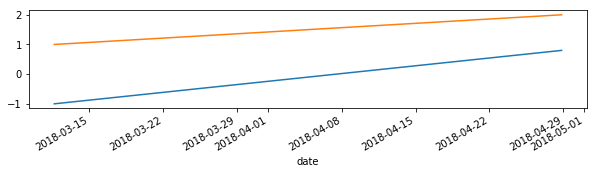

                                                  avg  bet  bets  profit
idx_1                         idx_2                                     
A_RECLAMER_AMATEURS_AUTOSTART pred_stacked_mlp_1 -1.0    1     1    -1.0
                              pred_xgb_10_1      -1.0    1     1    -1.0
                              pred_rnd           -1.0    1     1    -1.0
                              pred_knn_5_1       -1.0    1     1    -1.0


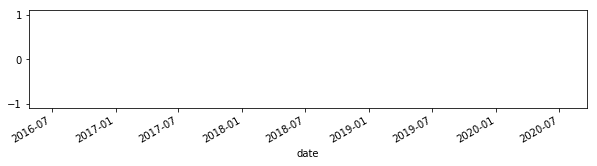

In [21]:
#bb = bets
bb = bets[ (bets['country']!='gFRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & (bets['odds_ref']>=5) & (bets['odds_ref']<30) ]
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & (bets['odds_ref']>=bets['odds_1']) & (bets['odds_ref']<20) & (bets['target']!='psred_mlp_20_1') ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']=='AUTOSTART') & (bets['nb']<=0) & (bets['odds_ref']>=0) & (bets['odds_ref']<20) ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & ( (bets['target']=='pred_knn_10_1') | (bets['target']=='pred_minus_ref_lasso_1') ) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>20)].copy()        
#bb = bets[ (bets['country']=='FRA') & (bets['nb']==0) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>0)].copy()
#bb = bb.groupby('id').filter(lambda r: r['num'].count() == 2)
#graph_bb( bets[(bets['target']=='pred_lasso_0.1_1') & (bets['nb']==0) & (bets['odds_ref']>5) & (bets['odds_ref']<20) & (bets['pred']>0.)], 'sub_category')
#bb['profit'] = bb['profit'] * 1/(1+bb['nb'])
#bb['bet'] = bb['bet'] * 1/(1+bb['nb'])
graph_bb(bb, 'sub_category')




In [16]:
bets[ (bets['target'] == 'pred_stacked_xgb_1') & (bets['pred']<1) ]['profit'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: profit, dtype: float64

In [17]:
bets[(bets['nb']<=0) & (bets['declared_player_count'] == 12) & (bets['target']=='pred_stacked_lasso_1')  & (bets['odds_ref']>0) & (bets['odds_ref']<30) & (bets['pred']>0.)]

,id,date,num,pos,nb,odds_ref,odds_final,target,pred,pred_std,bet,profit,next_pred_1,next_pred_2,next_pred_3,declared_player_count,handicap_distance,handicap_distance_amax,handicap_distance_amin,handicap_distance_mean,handicap_distance_r,handicap_distance_std,handicap_weight,handicap_weight_amax,handicap_weight_amin,handicap_weight_mean,handicap_weight_r,handicap_weight_std,hist_1_pos,hist_2_pos,hist_3_pos,hist_4_pos,hist_5_pos,hist_6_pos,odds_0,odds_1,odds_2,odds_3,odds_4,odds_5,odds_6,odds_7,odds_8,odds_9,placed_2_count,placed_2_count_amax,placed_2_count_amin,placed_2_count_mean,placed_2_count_r,placed_2_count_std,placed_3_count,placed_3_count_amax,placed_3_count_amin,placed_3_count_mean,placed_3_count_r,placed_3_count_std,placed_earnings,placed_earnings_amax,placed_earnings_amin,placed_earnings_mean,placed_earnings_r,placed_earnings_std,prev_year_earnings,prev_year_earnings_amax,prev_year_earnings_amin,prev_year_earnings_mean,prev_year_earnings_r,prev_year_earnings_std,prize,race_count,race_count_amax,race_count_amin,race_count_mean,race_count_r,race_count_std,victory_count,victory_count_amax,victory_count_amin,victory_count_mean,victory_count_r,victory_count_std,victory_earnings,victory_earnings_amax,victory_earnings_amin,victory_earnings_mean,victory_earnings_r,victory_earnings_std,category,sub_category,country,bets,stash
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [18]:
df['placed_3_count'].describe()

count    26512.000000
mean         1.983970
std          2.902189
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         29.000000
Name: placed_3_count, dtype: float64

In [36]:
df = program.df


races = df.groupby('race_id')

strat_df = {
    'race_id': [],
    'strat1': []
}

for (id, race) in races:

    r = race.sort_values(by='final_odds_ref', ascending=True)

    strat1 = 0

    bets = [6, 3, 1.5]

    for n in range(3):
        strat1 += r.iloc[n]['winner_dividend']/100.0 * bets[n] - bets[n]

    strat_df['race_id'].append(id)
    strat_df['strat1'].append(strat1)



In [37]:
strat_df = pd.DataFrame({'race_id': strat_df['race_id'], 'strat1': strat_df['strat1']})




In [43]:
strat_df

,race_id,strat1
0,11123,1.50
1,11139,-2.10
2,11140,-2.10
3,11142,6.45
4,11143,-10.50
5,11144,0.00
6,11145,3.90
7,11146,9.00
8,11147,1.50
9,11162,-10.50


In [44]:
#df2 = df.join(strat_df, on="race_id", lsuffix="_left", rsuffix="_right")
df2 = pd.merge(left=df, right=strat_df, on='race_id', how='left')

In [45]:
df2['strat1']

0         1.50
1         1.50
2         1.50
3         1.50
4         1.50
5         1.50
6         1.50
7         1.50
8         1.50
9         1.50
10        1.50
11        1.50
12       -2.10
13       -2.10
14       -2.10
15       -2.10
16       -2.10
17       -2.10
18       -2.10
19       -2.10
20       -2.10
21       -2.10
22       -2.10
23       -2.10
24       -2.10
25       -2.10
26       -2.10
27       -2.10
28       -2.10
29       -2.10
30       -2.10
31       -2.10
32       -2.10
33       -2.10
34       -2.10
35       -2.10
36       -2.10
37       -2.10
38       -2.10
39       -2.10
40       -2.10
41        6.45
42        6.45
43        6.45
44        6.45
45        6.45
46        6.45
47        6.45
48        6.45
49        6.45
50        6.45
51        6.45
52        6.45
53        6.45
54      -10.50
55      -10.50
56      -10.50
57      -10.50
58      -10.50
59      -10.50
60      -10.50
61      -10.50
62      -10.50
63      -10.50
64      -10.50
65        0.00
66        